In [1]:
# Import
import torch
import torch.nn as nn
import numpy as np
from dataloader import BatchDataloader
from tqdm.notebook import trange, tqdm
import h5py
from torch.utils.data import TensorDataset, random_split, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['style.mpl'])
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
from utils import pgd_attack, eval_loop, filter_adversarial, eval_loop_apgd
from models import ResNet1dGELU
import ecg_plot
from utils import plot_ecgs
import ast
%matplotlib inline

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

Use device: cuda



In [3]:
# hyperparameters
batch_size = 32

In [4]:
from sklearn.metrics import mean_squared_error

# Load the data
dataset_path = '/local_storage/users/arveri/ptb-xl'

path_to_csv, path_to_records, path_to_scp = dataset_path + '/ptbxl_database.csv', dataset_path + '/RECORDS', dataset_path + '/scp_statements.csv'
path_to_train, path_to_val, path_to_test = dataset_path + '/train.h5', dataset_path + '/val.h5', dataset_path + '/test.h5'

# Get labels
df = pd.read_csv(path_to_csv, index_col='ecg_id')
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path_to_scp, index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def has_key(dic, key_str):
    for key in dic.keys():
        if key == key_str:
            return 1
    return 0

# Apply diagnostic superclass
df['AF'] = df.scp_codes.apply(lambda x: has_key(x, 'AFIB'))

validation_fold = 9
test_fold = 10

# Load labels
train = df[(df.strat_fold != validation_fold) & (df.strat_fold != test_fold)]
val = df[df.strat_fold == validation_fold]
test = df[df.strat_fold == test_fold]

labels_train = train['age'].values
labels_val = val['age'].values
labels_test = test['age'].values

# Make them torch tensors
labels_train = torch.tensor(labels_train, dtype=torch.float32).reshape(-1,1)
labels_val = torch.tensor(labels_val, dtype=torch.float32).reshape(-1,1)
labels_test = torch.tensor(labels_test, dtype=torch.float32).reshape(-1,1)

# Define traces
traces_train = h5py.File(path_to_train, 'r')['tracings']
traces_val = h5py.File(path_to_val, 'r')['tracings']
traces_test = h5py.File(path_to_test, 'r')['tracings']

# Remove all traces where the label equals 300.0
# Find indices
indices = []
for i in range(len(labels_train)):
    if labels_train[i] == 300.0:
        indices.append(i)
# Remove traces
traces_train = np.delete(traces_train, indices, axis=0)
labels_train = np.delete(labels_train, indices, axis=0)

indices = []
for i in range(len(labels_val)):
    if labels_val[i] == 300.0:
        indices.append(i)
# Remove traces
traces_val = np.delete(traces_val, indices, axis=0)
labels_val = np.delete(labels_val, indices, axis=0)

indices = []
for i in range(len(labels_test)):
    if labels_test[i] == 300.0:
        indices.append(i)
# Remove traces
traces_test = np.delete(traces_test, indices, axis=0)
labels_test = np.delete(labels_test, indices, axis=0)





# Define dataloaders
train_dataloader = BatchDataloader(traces_train, labels_train, batch_size=batch_size)
val_dataloader = BatchDataloader(traces_val, labels_val, batch_size=batch_size)
test_dataloader = BatchDataloader(traces_test, labels_test, batch_size=batch_size)

In [5]:
eps_list = [0, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1]
loss_function = nn.MSELoss()

# Create dictionary for storing metrics for each model
metrics = {}

for model_path in ['../models/age/ptb_20/latest.pth', "../models/age/ptb_20_apgd_1e-2/latest.pth", "../models/age/ptb_20_apgd_5e-2/latest.pth"]:
    # Define the model
    model = ResNet1dGELU(input_dim=(12, 4096),n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8
    checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint['model'])
    model.to(device)

    metrics[model_path] = {}

    for eps in eps_list:
        # Evaluate with adversarial examples
        adv_valid_loss, adv_y_pred, adv_y_true = eval_loop_apgd(0, test_dataloader, model, loss_function, device, adversarial=True, adv_eps=eps, adv_iters=10, adv_restarts=1)

        mse = mean_squared_error(adv_y_true, adv_y_pred)

        # store the metrics for this model
        metrics[model_path][eps] = {'mse': mse}
        
        # print outliers between adv_y_true and adv_y_pred where the difference is larger than 100
        outliers = np.where(np.abs(adv_y_true - adv_y_pred) > 100)
        # print the number of outliers and the difference
        print(f"Model: {model_path}, eps: {eps}, outliers: {len(outliers[0])}, difference: {np.abs(adv_y_true[outliers] - adv_y_pred[outliers])}")
        


    # # Print table comparing results
    # from tabulate import tabulate

    # table = [["", "Accuracy", "AUROC", "AUPRC", "F1"],
    #             ["No adversarial", accuracy, auroc, ap, f1],
    #             ["Adversarial", adv_accuracy, adv_auroc, adv_ap, adv_f1]]
    # print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

Evaluation Epoch  0:   0%|          | 0/69 [00:00<?, ?it/s]

In [6]:
import json

# Convert all metrics to floats
for model_path, model_metrics in metrics.items():
    for eps, eps_metrics in model_metrics.items():
        for metric, value in eps_metrics.items():
            metrics[model_path][eps][metric] = float(value)

# Save these metrics to a file
for model_path, model_metrics in metrics.items():
    save_path = model_path.replace('.pth', '_apgd_eval_ptb.json')
    print(model_metrics)
    with open(save_path, 'w') as f:
        json.dump(model_metrics, f)

{0: {'mse': 969.6473}, 0.001: {'mse': 1054.0962}, 0.005: {'mse': 1725.1543}, 0.01: {'mse': 2808.4065}, 0.05: {'mse': 7235.621}, 0.1: {'mse': 8218.755}, 0.5: {'mse': 9568.817}}


TypeError: Object of type float32 is not JSON serializable

In [43]:
import json
# load the metrics

metrics = {}

# for model_path in ['../models/sex/ptb_20/latest.pth', "../models/sex/ptb_20_apgd_5e-2/latest.pth", "../models/sex/ptb_20_apgd_1e-2/latest.pth"]:
#     with open(model_path.replace('.pth', '_apgd_eval_ptb.json'), 'r') as f:
#         metrics[model_path] = json.load(f)
        
# for loading afib

# metrics = {}

for metric_path in ['../models/afib/model_latest_20_apgd_eval_ptb.json', "../models/afib/model_latest_adv_20_5e-2exp_apgd_apgd_eval_ptb.json", "../models/afib/model_latest_adv_20_0.01exp_apgd_apgd_eval_ptb.json"]:
    with open(metric_path, 'r') as f:
        metrics[metric_path] = json.load(f)

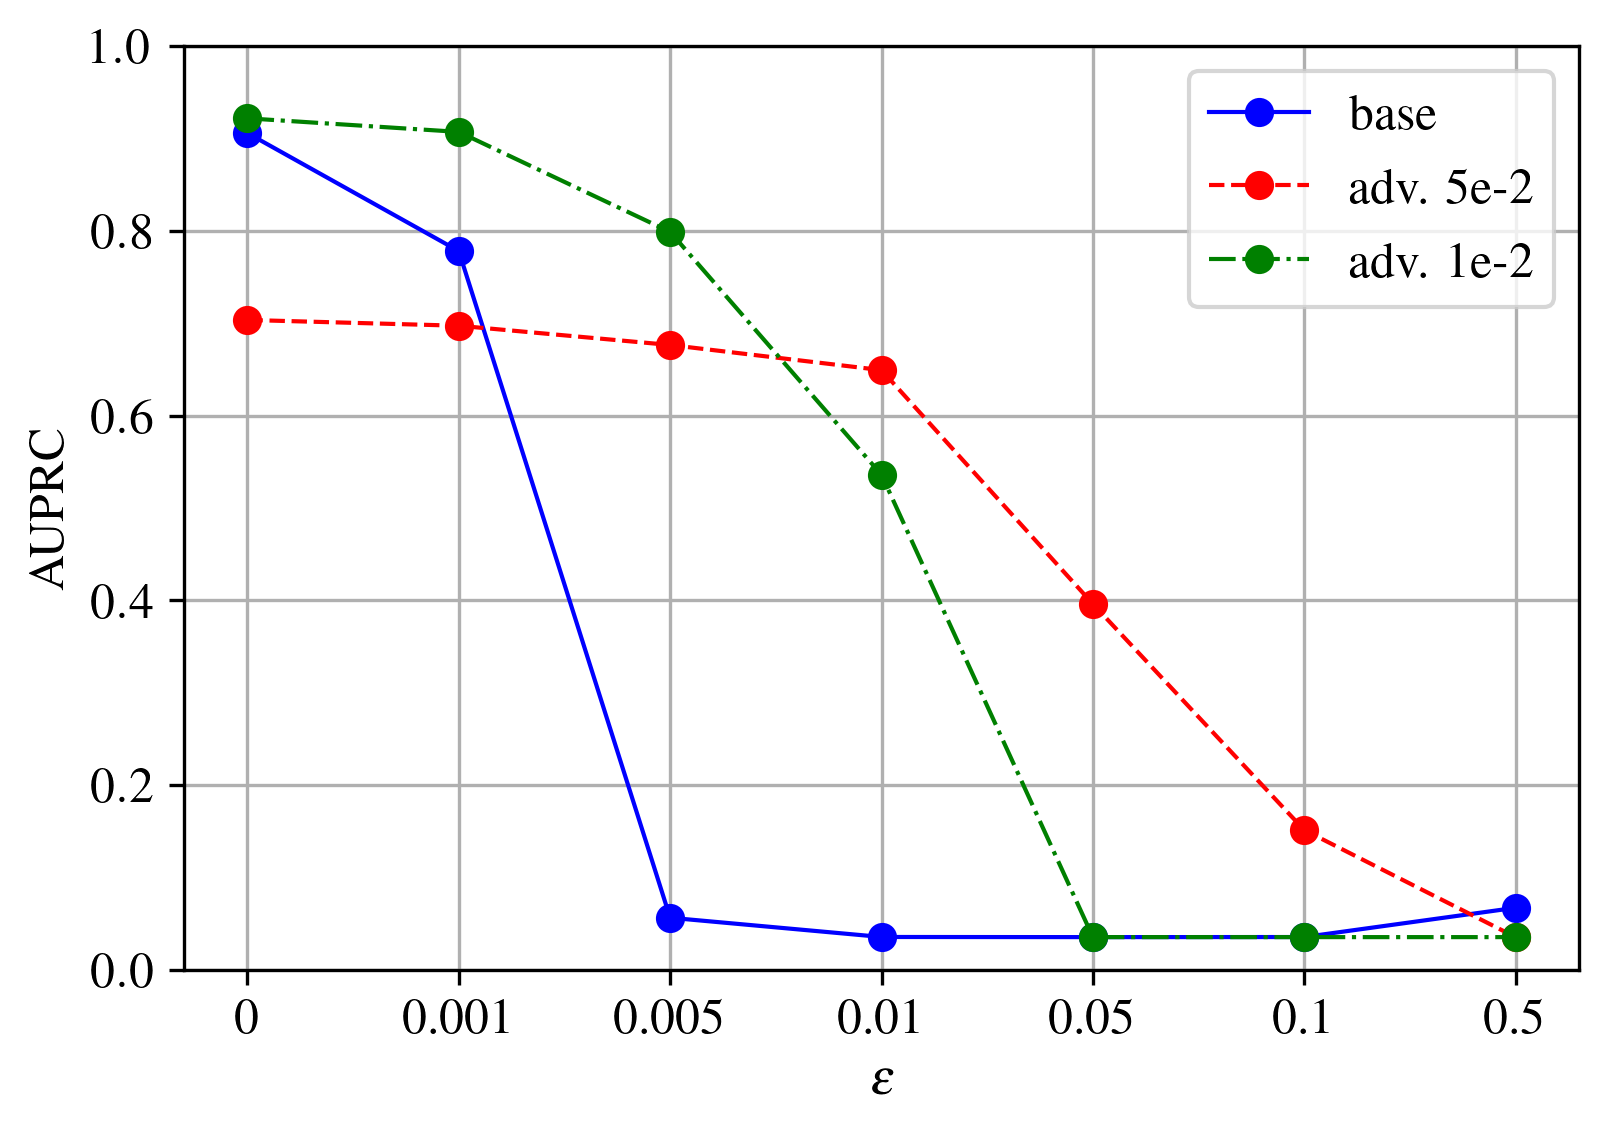

In [45]:
import utils
from importlib import reload
import autopgd_base
from matplotlib.ticker import AutoMinorLocator
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
plt.style.use(['../figures/style.mpl'])

# plot the accuracy for each model and each epsilon
labels = ['base', 'adv. 5e-2', 'adv. 1e-2']
colors = ['blue', 'red', 'green']
linestyles = ['-', '--', '-.']
eps_list = [0, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1]


for model_path, color, linestyle, label in zip(metrics, colors, linestyles, labels):
    # get the metrics for this model
    model_metrics = metrics[model_path]
    
    # get the accuracy for each epsilon
    acc = [model_metrics[eps]['ap'] for eps in model_metrics]
    
    # plot the accuracy
    plt.plot([str(eps) for eps in eps_list], acc, label=label, marker='o', linestyle=linestyle, linewidth=1, color=color)
    
plt.grid()

# change figure size
fig = plt.gcf()
fig.set_size_inches(6, 4)

# make it higher resolution
mpl.rcParams['figure.dpi'] = 300

# Set font size
plt.xticks(fontsize=12)
# make y ticks every 0.2
plt.yticks(np.arange(0, 1.2, 0.2), fontsize=12)

# make the y axis be log scale
#plt.yscale('log')
# make labels on all y ticks
plt.yticks(fontsize=12)


# set remaining fonts such as axis and legend
plt.legend(fontsize=12)
plt.xlabel('$\epsilon$', fontsize=12)
plt.ylabel('AUPRC', fontsize=12)

plt.ylim(0, 1)
# save as pdf
plt.savefig('../figures/afib_apgd_eval.pdf', bbox_inches='tight')
plt.show()

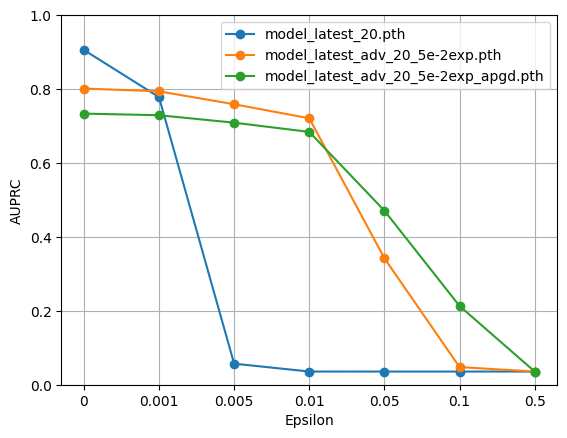

In [21]:
# plot the ap for each model and each epsilon
for model_path in metrics:
    # get the metrics for this model
    model_metrics = metrics[model_path]
    
    # get the accuracy for each epsilon
    ap = [model_metrics[eps]['ap'] for eps in model_metrics]
    
    # plot the accuracy
    ax.plot([str(eps) for eps in eps_list], ap, label=model_path, marker='o')

ax.xlabel('Epsilon')
ax.ylabel('AUPRC')
ax.grid()

ax.ylim(0, 1)
ax.legend()

ax.show()

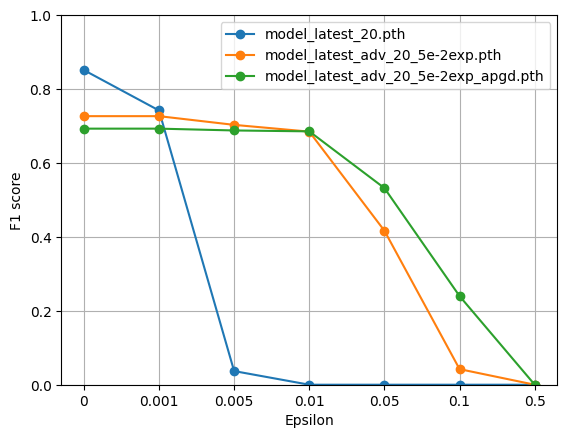

In [22]:
# plot the f1 score for each model and each epsilon
for model_path in metrics:
    # get the metrics for this model
    model_metrics = metrics[model_path]
    
    # get the accuracy for each epsilon
    f1 = [model_metrics[eps]['f1'] for eps in model_metrics]
    
    # plot the accuracy
    plt.plot([str(eps) for eps in eps_list], f1, label=model_path, marker='o')
    
plt.xlabel('Epsilon')
plt.ylabel('F1 score')
plt.grid()

plt.ylim(0, 1)
plt.legend()

plt.show()

In [6]:
model = ResNet1dGELU(input_dim=(12, 4096),n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8
checkpoint = torch.load("models/model_latest_20.pth", map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model'])
model = model.to(device)
print("Model loaded!")

Model loaded!


torch.Size([32, 4096, 12])
torch.Size([32, 1])


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


Loss:  8.026628494262695
(12, 4096)
(12, 4096)
Max difference:  0.01000005


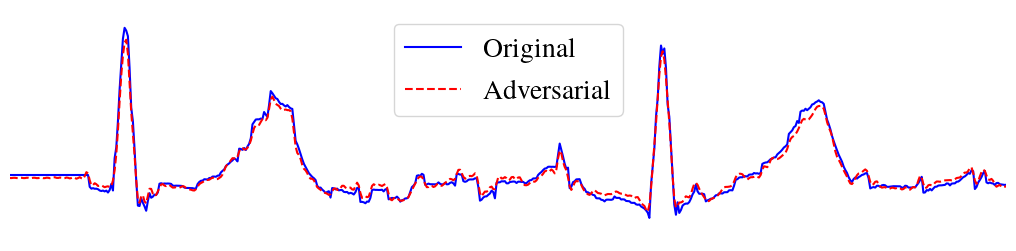

True class:  0.0
Predicted class:  0.9999991655349731


In [7]:
import utils
from importlib import reload
import autopgd_base
from matplotlib.ticker import AutoMinorLocator
import matplotlib as mpl
plt.style.use(['figures/style.mpl'])


reload(utils)
reload(autopgd_base)

model.eval()

eps = 1e-2
cuttoff_freq = 100

# Plot some adversarial examples
traces, diagnoses = next(iter(val_dataloader))

ecg_sample = np.transpose(traces[1].detach().cpu().numpy())

model = model.to(device)
traces = traces.to(device)
diagnoses = diagnoses.to(device)

#diagnoses = diagnoses.reshape(-1)


print(traces.shape)
print(diagnoses.shape)

attack = autopgd_base.APGDAttack(model, n_iter=10, norm='Linf', n_restarts=1, eps=eps, seed=0, loss='bce', eot_iter=1, rho=.75, device=device)
attack.init_hyperparam(traces)
(x_best, acc, loss_best, x_best_adv) = attack.attack_single_run(traces, diagnoses)

traces = x_best
 
# traces = pgd_attack(model, traces, diagnoses, device, eps=eps, alpha=eps/5, steps=10)

loss = nn.BCEWithLogitsLoss()
output = model(traces)
loss_val = loss(output, diagnoses)
print("Loss: ", loss_val.item())



ecg_sample_adv = np.transpose(traces[1].detach().cpu().numpy())


print(ecg_sample.shape)
print(ecg_sample_adv.shape)
# Calculate the maximum difference between the original and the adversarial example
max_diff = np.max(np.abs(ecg_sample - ecg_sample_adv))
print("Max difference: ", max_diff)

# Filter it
ecg_sample_adv = filter_adversarial(ecg_sample_adv, sample_rate=400, fc=cuttoff_freq)


# Select the first lead
ecg_sample = ecg_sample[0:1, :1024]

ecg_sample_adv = ecg_sample_adv[0:1, :1024]

# make x axis / 400 to get time in seconds
x = np.arange(0, 1024) / 400

# Plot using matplotlib
fig, ax = plt.subplots(figsize=(1.5*3*2/0.7, 3))
labels = ['Original', 'Adversarial']
# grid every 0.1
# plt.xticks(np.arange(0, 2.6, 0.2))
# plt.yticks(np.arange(-0.5, 0.5, 0.5))
# make the figure stop at 0 and 2.6

# ax.set_xticks(np.arange(0, 2.6, 0.2))    
# ax.set_yticks(np.arange(-0.5, 0.5, 0.5))

plt.xlim(0, 1.5)
plt.ylim(-0.2, 0.5)

# ax.minorticks_on()

# ax.xaxis.set_minor_locator(AutoMinorLocator(5))

# ax.grid(which='major', linestyle='-', linewidth=0.5)
# ax.grid(which='minor', linestyle='-', linewidth=0.5)
plt.plot(x, ecg_sample[0], label=labels[0], linestyle='-',  color='blue')
plt.plot(x, ecg_sample_adv[0], label=labels[1], linestyle='--', color='red')
# remove labels from x and y axis but keep ticks
plt.gca().axes.get_xaxis().set_ticklabels([])
plt.gca().axes.get_yaxis().set_ticklabels([])

# remove all spines and ticks
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')

# make outline thicker
plt.gca().spines['bottom'].set_linewidth(1)
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['top'].set_linewidth(1)
plt.gca().spines['right'].set_linewidth(1)

plt.legend(loc='upper center')
plt.show()

print("True class: ", diagnoses[1].item())
print("Predicted class: ", torch.sigmoid(output)[1].item())



# plt.figure()
# #lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'I-adv', 'II-adv', 'V1-adv', 'V2-adv', 'V3-adv', 'V4-adv', 'V5-adv', 'V6-adv']
# lead = ['I', 'I-adv', 'II', 'II-adv', 'V1', 'V1-adv', 'V2', 'V2-adv', 'V3', 'V3-adv', 'V4', 'V4-adv', 'V5', 'V5-adv', 'V6', 'V6-adv']
# #lead = ['I', 'I-adv']
# utils.plot_ecgs(ecg_sample, ecg_sample_adv, sample_rate=400, style = 'bw', row_height=3, lead_index=lead, columns=1, title="",show_zoom=False, zoom_box=[3.0, 4.0, -0.2, 0.3], zoom_rate=10)
# plt.legend(['Adversarial', 'Original'])
# plt.show()


# # Also plot them individually
# plt.figure()
# ecg_plot.plot(ecg_sample, sample_rate=400, title="Original ECG", columns=1)
# plt.show()

# plt.figure()
# ecg_plot.plot(ecg_sample_adv, sample_rate=400, title="Adversarial ECG", columns=1)
# plt.show()

In [27]:
eps = 5e-2
loss_function = nn.BCEWithLogitsLoss()

fcs = [1, 2, 5, 10, 20, 50, 75, 100, 125, 150]

# Create dictionary for storing metrics for each model
metrics = {}

for model_path in ['model_latest_20.pth', "model_latest_adv_20_5e-2exp.pth"]:
    # Define the model
    model = ResNet1dGELU(input_dim=(12, 4096),n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8
    checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(checkpoint['model'])
    model.to(device)
    
    metrics[model_path] = {}
    
    for fc in fcs:
        # Evaluate with adversarial examples
        adv_valid_loss, adv_y_pred, adv_y_true = eval_loop(0, val_dataloader, model, loss_function, device, adversarial=True, adv_eps=eps, adv_alpha=eps/5, adv_steps=10, post_process=filter_adversarial, post_process_args=[400, fc])

        adv_auroc = roc_auc_score(adv_y_true, adv_y_pred)
        adv_ap = average_precision_score(adv_y_true, adv_y_pred)

        # apply sigmoid to y_pred
        adv_y_pred = torch.sigmoid(torch.tensor(adv_y_pred)).numpy()
        adv_y_pred = np.round(adv_y_pred)

        # compute accuracy
        adv_accuracy = accuracy_score(adv_y_true, adv_y_pred)
        adv_f1 = f1_score(adv_y_true, adv_y_pred, average='binary')
        
        # store the metrics for this model
        metrics[model_path][fc] = {'accuracy': adv_accuracy, 'auroc': adv_auroc, 'ap': adv_ap, 'f1': adv_f1}

FileNotFoundError: [Errno 2] No such file or directory: 'model_latest_20.pth'

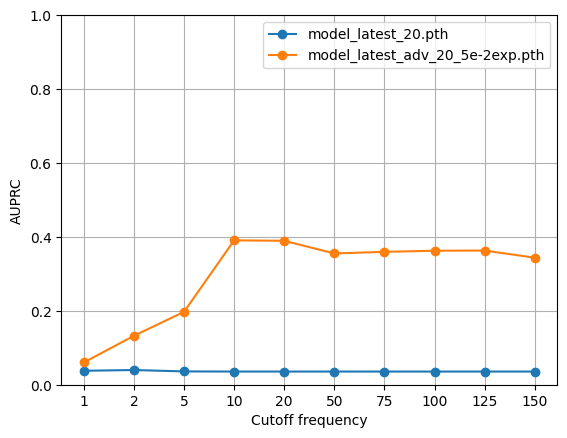

In [ ]:
# plot the ap for each model and each epsilon
for model_path in metrics:
    # get the metrics for this model
    model_metrics = metrics[model_path]
    
    # get the accuracy for each epsilon
    ap = [model_metrics[fc]['ap'] for fc in model_metrics]
    
    # plot the accuracy
    plt.plot([str(fc) for fc in fcs], ap, label=model_path, marker='o')

plt.xlabel('Cutoff frequency')
plt.ylabel('AUPRC')
plt.grid()

plt.ylim(0, 1)
plt.legend()

plt.show()
